In [1]:
# Imports
from ypstruct import structure
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import re
import pandas as pd
import seaborn as sns

In [2]:
def read_TTP_instance_data(file_path: str) -> dict:

    """
    Read TTP (Travelling Thief Problem) instance data from a given file.

    Parameters:
    - file_path (str): Path to the TTP instance file.

    Returns:
    dict: A dictionary containing the following information:
        - "nb_cities" (int): Number of cities.
        - "nb_items" (int): Number of items.
        - "Q" (int): Maximum capacity of the knapsack.
        - "v_min" (float): Minimum speed of the thief.
        - "v_max" (float): Maximum speed of the thief.
        - "R" (float): Renting ratio.
        - "pairwise_distances" (numpy.ndarray): Pairwise distances between cities.
        - "item_to_city_mapping_dict" (dict): Dictionary where the key is the city id
          and the value is a list of item ids at that city.
        - "item_weights" (numpy.ndarray): Array containing weights of all items.
        - "item_values" (numpy.ndarray): Array containing values of all items.
        - "value_to_weight_ratio_dict" (dict): Dictionary where the key is the item id
          and the value is the value-to-weight ratio for that item.
    """
    
    nb_items = int(file_path.split("-")[1].strip("n").split(".txt")[0])
    nb_cities = int(re.sub("\D", "", file_path.split("-")[0].split("/")[2]))
    # Read node coordinates from the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Initialize variables
    node_coordinates = []
    item_values = []
    item_weights= []
    in_node_section = False
    in_item_section = False
    item_to_city_mapping_dict = {}
    v_min = None
    v_max = None
    max_capacity = None
    renting_ratio = None

    for i in range(nb_cities):
        item_to_city_mapping_dict[i] = []

    # Extract node coordinates and item data
    for line in lines:
        if line.startswith("CAPACITY OF KNAPSACK"):
            max_capacity = int(line.strip().split()[3])
            continue
        elif line.startswith("MIN SPEED"):
            v_min = float(line.strip().split()[2])
        elif line.startswith("MAX SPEED"):
            v_max = float(line.strip().split()[2])
        elif line.startswith("RENTING RATIO"):
            renting_ratio = float(line.strip().split()[2])
        elif line.startswith('NODE_COORD_SECTION'):
            in_node_section = True
            in_item_section = False
            continue
        elif line.startswith('ITEMS SECTION'):
            in_node_section = False
            in_item_section = True
            continue
        elif line.startswith('EOF'):
            break
        
        if in_node_section:
            _, x, y = map(int, line.strip().split())
            node_coordinates.append((x, y))
        elif in_item_section:
            item_id, profit, weight, node_number = map(int, line.strip().split())
            item_to_city_mapping_dict[node_number - 1].append(item_id-1) # re-index to 0
            item_values.append(profit)
            item_weights.append(weight)
    
    value_to_weight_ratio = np.array(item_values) / np.array(item_weights)
    value_to_weight_ratio_dict = dict(zip(list(range(len(value_to_weight_ratio))), value_to_weight_ratio))
    
    return {"nb_cities": nb_cities,
            "nb_items": nb_items,
            "Q": max_capacity, 
            "v_min": v_min, 
            "v_max": v_max, 
            "R": renting_ratio, 
            "pairwise_distances": pdist(node_coordinates), 
            "item_to_city_mapping_dict":item_to_city_mapping_dict,
            "item_weights": np.array(item_weights),
            "item_values": np.array(item_values),
            "value_to_weight_ratio_dict": value_to_weight_ratio_dict
            }

In [3]:
def random_tour(nb_cities: int) -> list:
    
    """
    Create a random permutation of the cities for the TTP

    Parameters:
    - nb_cities (int): Number of cities

    Returns:
    list: A list which is a random permutation of the cities.
    """
        
    return random.sample(list(range(nb_cities)), k = nb_cities)

In [4]:
def pack_one(init_pop: list[structure], nb_items: int) -> list:

    """
    Randomly selects one item for packing in each candidate solution of the initial population.

    Parameters:
    - init_pop (list): List of candidate solutions represented as structures
      from the ypstruct library with the following attributes:
        - tour (list): An array representing the sequence of cities visited.
    - nb_items (int): Number of items to be considered for packing.

        
    This function modifies the 'packing_plan' attribute of each candidate solution in the 
    input population, assigning a binary packing plan with one randomly chosen item.

    Returns:
    list: Updated initial population with one item randomly packed in each candidate solution.
    """

    for candidate_solution in init_pop:
        packing_plan = np.zeros(nb_items)
        chosen_item = random.sample(list(range(nb_items)), k = 1)
        packing_plan[chosen_item] = 1
        candidate_solution.packing_plan = list(packing_plan)
    return init_pop

In [5]:
def repair_packing_plan(candidate_solution: structure, Q: float, item_weights: np.ndarray) -> None:

    """
    Repair the packing plan of a candidate solution to satisfy the capacity constraint.

    Parameters:
    - candidate_solution (ypstruct.structure): A candidate solution represented as structures
      from the ypstruct library with the following attributes:
        - tour (list): An array representing the sequence of cities visited.
        - packing_plan (numpy.ndarray): A binary array indicating items picked (1) or not (0).
    - Q (float): The maximum capacity constraint for the packing plan.
    - item_weights (numpy.ndarray): Array containing the weights of individual items.

    This function modifies the packing plan of the input "candidate_solution" object in-place
    to ensure that the total weight does not exceed the specified capacity "Q". It randomly
    selects items to remove until the maximum capacity is no longer exceeded.

    Returns:
    None
    """
    
    packing_plan = np.array(candidate_solution.packing_plan)
    selected_items = list(np.nonzero(packing_plan))
    selected_items_weights = item_weights[selected_items]
    while np.sum(selected_items_weights) > Q:
        candidate_solution.packing_plan[random.sample(list(selected_items[0]), k = 1)[0]] = 0
        packing_plan = np.array(candidate_solution.packing_plan)
        selected_items = list(np.nonzero(packing_plan))
        selected_items_weights = item_weights[selected_items]
    candidate_solution.packing_plan = list(packing_plan)
    return None

In [6]:
def pack_random(init_pop: list[structure], Q: float, item_weights: np.ndarray) -> list:

    """
    Initialize the packing plans of a population of candidate solutions randomly.

    Parameters:
    - init_pop (list): List of candidate solutions represented as structures
      from the ypstruct library with the following attributes:
        - tour (list): An array representing the sequence of cities visited.
    - Q (float): The maximum capacity constraint for the packing plans.
    - item_weights (numpy.ndarray): Array containing the weights of individual items.

    Returns:
    list: The input population ("init_pop") with packing plans initialized randomly.
          Each candidate solution's packing plan is generated randomly and then repaired
          to ensure it satisfies the specified capacity constraint "Q".
    """
    
    nb_items = len(item_weights)
    for candidate_solution in init_pop:
        packing_plan = [random.choice(list(range(2))) for _ in range(nb_items)]
        candidate_solution.packing_plan = packing_plan
        repair_packing_plan(candidate_solution, Q, item_weights)
    return init_pop

In [7]:
def pack_optimal(init_pop: list[structure], Q: float, value_to_weight_ratio_dict: dict, item_weights: np.ndarray) -> list:

    """
    Initialize the packing plans of a population of candidate solutions optimally based on value-to-weight ratios.

    Parameters:
    - init_pop (list): List of candidate solutions represented as structures
      from the ypstruct library with the following attributes:
        - tour (list): An array representing the sequence of cities visited.
    - Q (float): The maximum capacity constraint for the packing plans.
    - value_to_weight_ratio_dict (dict): A dictionary containing item ids as keys and corresponding value-to-weight ratios.
    - item_weights (numpy.ndarray): Array containing the weights of individual items.

    Returns:
    list: The input population ("init_pop") with packing plans initialized optimally.
          Each candidate solution's packing plan is generated based on the highest value-to-weight ratios,
          ensuring that the total weight does not exceed a randomly generated Q' such that 0 <=  Q' < Q.
    """

    number_of_items = len(item_weights)
    
    sorted_value_to_weight_ratio_dict = dict(sorted(value_to_weight_ratio_dict.items(), key=lambda x:x[1], reverse = True))
    keys_list = list(sorted_value_to_weight_ratio_dict.keys())

    for candidate_solution in init_pop:
        Q_prime = np.random.randint(low = 0, high = Q, size = 1)
        packing_plan = np.zeros(number_of_items)
        weight  = 0
        for i in range(number_of_items):
            if weight + item_weights[keys_list[i]] < Q_prime:

                packing_plan[keys_list[i]] = 1
                weight += item_weights[keys_list[i]]
            else:
                break
        candidate_solution.packing_plan = list(packing_plan)
    return init_pop

In [8]:
def generate_initial_population(pop_size: int, nb_cities: int, pack_init_method: str, tour_init_method: str, Q: float = None, value_to_weight_ratio_dict: dict = None, item_weights: np.ndarray = None) -> list: # Jack

    """
    Generate an initial population of candidate solutions for the Travelling Thief Problem (TTP).

    Parameters:
    - pop_size (int): The size of the population.
    - nb_cities (int): Number of cities in the TTP instance.
    - pack_init_method (str): Method for initializing the packing plans ("pack_random", "pack_one", "pack_optimal").
    - tour_init_method (str): Method for initializing the tours ("random").
    - Q (float, optional): Maximum capacity constraint for packing plans.
    - value_to_weight_ratio_dict (dict, optional): Dictionary containing value-to-weight ratios for items.
    - item_weights (numpy.ndarray, optional): Array containing the weights of individual items.

    Returns:
    list: List of candidate solutions represented as structures
        from the ypstruct library with the following attributes:
        - tour (list): A list representing the sequence of cities visited.
        - packing_plan (list): A list representing the packing plan
    """
    init_pop = []
    if tour_init_method == "random":
        for _ in range(pop_size):
            candidate_solution = structure()
            candidate_solution.tour = random_tour(nb_cities)
            init_pop.append(candidate_solution)

    if pack_init_method == "pack_random":
        pack_random(init_pop, Q, item_weights)
    elif pack_init_method == "pack_one":
        pack_one(init_pop, len(item_weights))
    elif pack_init_method == "pack_optimal":    
        pack_optimal(init_pop, Q, value_to_weight_ratio_dict, item_weights)
    return init_pop

Cost function for the knapsack, as given by:
$$
  \sum^m_{j = 1} z_j * b_j
$$
where $z_j$ is the a binary vector where each index corresponds to an item and is 0 if the item is not picked and 1 if it is and $b_j$ is the values vector.

In [9]:
def knapsack_cost(candidate_solution: structure, item_values: np.ndarray) -> float:
    
    """
    Calculate the total cost of a candidate solution in a knapsack problem.

    Parameters:
    - candidate_solution (ypstruct.structure): A candidate solution represented as a structure
        from the ypstruct library with the following attributes:
        - tour (list): A list representing the sequence of cities visited.
        - packing_plan (list): A list representing the packing plan
    - item_values (numpy.ndarray): An array of values corresponding to each item
      in the knapsack. The first value corresponds to the value of the first item, the second corresponds to the value for the second, 
      etc...

    Returns:
    - float: The total cost of the candidate solution, computed as the sum of
      selected item values in the knapsack.
    """
    
    return np.sum(np.array(candidate_solution.packing_plan) * item_values)

Cost function for the tour, taking into account velocity, as given by:
$$
    f(\pi, z) = \frac{d_{\pi_1, \pi_{n}} * R}{v(w(\pi_{n}))} + \sum^{n-1}_{i = 1} \frac{d_{\pi_i, \pi_{i+1}} * R}{v(w(\pi_{i}))}
$$ 
where 
$$
    w(\pi_i) = \sum^{i}_{k=1}\sum^{m}_{j=1} z_j * b_j * a_{j, \pi_i}
$$ 

and 
$$
    v(q) = v_{max} - \frac{q}{Q} * (v_{max} - v_{min})
$$ 

where $d_{\pi_i, \pi_{i+1}}$ is the distance between city $i$ and $i+1$, obtained from the distance matrix $d$ and $a$ is the item mapping matrix and R is the renting ratio

In [10]:
def get_pdist_distance(pairwise_distances: np.ndarray, i: int, j: int, nb_cities: int) -> float:

   """
    Retrieve the pairwise distance between two cities based on a condensed distance matrix, as returned by the
    pdist function from the scipy library.

    Parameters:
    - pairwise_distances (np.ndarray): Array representing the condensed pairwise distance matrix.
    - i (int): Index of the first city.
    - j (int): Index of the second city.
    - nb_cities (int): Total number of cities.

    Returns:
    float: Pairwise distance between the cities with indices "i" and "j" in the condensed
           pairwise distance matrix.
   """
   
   if i < j:
      return pairwise_distances[nb_cities * i + j - ((i + 2) * (i + 1)) // 2]
   elif i > j:
      return pairwise_distances[nb_cities * j + i - ((j + 2) * (j + 1)) // 2]


In [11]:
def tour_cost_pdist(candidate_solution: list[structure], pairwise_distances: np.ndarray, item_to_city_mapping_dict: dict, item_weights: np.ndarray, vmax: float, vmin: float, Q: float, renting_ratio: float) -> float:

    """
    Calculate the cost of a candidate solution's tour, considering travel distance and knapsack constraints.

    Parameters:
    - candidate_solution (ypstruct.structure): A candidate solution represented as a structure
        from the ypstruct library with the following attributes:
        - tour (list): A list representing the sequence of cities visited.
        - packing_plan (list): A list representing the packing plan
    - pairwise_distances (numpy.ndarray): Pairwise distances between cities as returned by the pdist function
        from the scipy library.
    - item_to_city_mapping_dict (dict): Dictionary mapping city ids to lists of item ids at that city.
    - item_weights (numpy.ndarray): Array containing the weights of individual items.
    - vmax (float): Maximum speed of the thief.
    - vmin (float): Minimum speed of the thief.
    - Q (float): Maximum capacity constraint for the packing plan.
    - renting_ratio (float): Renting ratio affecting the cost calculation.

    Returns:
    float: The total cost of the candidate solution's tour, considering travel distance and knapsack constraints.
           The cost is calculated as the sum of distances traveled, adjusted for the thief's velocity and
           the renting ratio for the knapsack value.
    """

    tour = candidate_solution.tour
    nb_cities = len(tour)

    weight = 0
    distance = 0
    for i in range(len(tour) - 1):
        weight +=  sum(np.array(candidate_solution.packing_plan)[item_to_city_mapping_dict[tour[i]]] * item_weights[item_to_city_mapping_dict[tour[i]]])
        velocity = vmax - weight / Q * (vmax - vmin)
        distance += get_pdist_distance(pairwise_distances, tour[i], tour[i+1], nb_cities) / velocity
    weight += sum(np.array(candidate_solution.packing_plan)[item_to_city_mapping_dict[tour[-1]]] * item_weights[item_to_city_mapping_dict[tour[-1]]])
    velocity = vmax - weight / Q * (vmax - vmin)
    distance += get_pdist_distance(pairwise_distances, tour[0], tour[-1], nb_cities) / velocity

    return distance * renting_ratio

In [12]:
def evaluate_candidate_solution_cost_pdist(candidate_solution: list[structure], pairwise_distances: np.ndarray, item_to_city_mapping_dict: dict, item_weights: np.ndarray, item_values: np.ndarray, vmax: float, vmin: float, Q: float, renting_ratio: float) -> structure:
    
    """
    Evaluate the cost of a candidate solution by calculating the total tour cost and packing plan cost.

    Parameters:
    - candidate_solution (ypstruct.structure): A candidate solution represented as a structure
        from the ypstruct library with the following attributes:
        - tour (list): A list representing the sequence of cities visited.
        - packing_plan (list): A list representing the packing plan
    - pairwise_distances (numpy.ndarray): Array of pairwise distances between cities.
    - item_to_city_mapping_dict (dict): Dictionary mapping city ids to lists of item ids at that city.
    - item_weights (numpy.ndarray): Array of weights for each item.
    - item_values (numpy.ndarray): Array of values for each item.
    - vmax (float): Maximum velocity for the thief.
    - vmin (float): Minimum velocity for the thief.
    - Q (float): Capacity of the knapsack (vehicle capacity).
    - renting_ratio (float): Renting ratio for the knapsack problem.

    Returns:
    - candidate_solution (ypstruct.structure): The candidate solution object with additional tour_cost and packing_plan_cost attributes.
    """
    
    candidate_solution.tour_cost = tour_cost_pdist(candidate_solution, pairwise_distances, item_to_city_mapping_dict, item_weights, vmax, vmin, Q, renting_ratio)
    candidate_solution.packing_plan_cost = knapsack_cost(candidate_solution, item_values)
    return candidate_solution

In [13]:
def get_ranks(population): # Ursula
    """
    Adds a value, rank to every candidate solution in a list of structures based on non dominated sort and the 
    rank of pareto front of all candidate solutions.
    
    
    Parameters:
    - population (list): List of candidate solutions represented as structures
      from the ypstruct library with the following attributes:
        - tour (list): An array representing the sequence of cities visited.
        - packing_plan (list): A binary array indicating items picked (1) or not (0).
        - packing_plan_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
        
    Returns:
    -none augments the population without need to return
    
    """
    #Current front set
    f = []
    #Sets for the entire population
    big_s = []
    #dominant individuals for the entire population
    big_np = []
    for p in population:
        #S is the set of individuals that are dominated by p
        s = []
        #np = the number of individuals that dominate p
        np = 0
        for q in population:
            if q.packing_plan_cost < p.packing_plan_cost and q.tour_cost >= p.tour_cost:
                s.append(q)
            elif q.packing_plan_cost <= p.packing_plan_cost and q.tour_cost > p.tour_cost:
                s.append(q)
            elif q.packing_plan_cost > p.packing_plan_cost and q.tour_cost <= p.tour_cost:
                np +=1
            elif q.packing_plan_cost >= p.packing_plan_cost and q.tour_cost < p.tour_cost:
                np +=1
        if np == 0:
            p.rank = 1
            f.append(p)
    
        big_s.append(s)
        big_np.append(np)
    front_counter = 1
    while len(f) != 0:
        #individuals from the i+1 front
        q = []
        for y in f:
            for x in big_s[population.index(y)]:
                big_np[population.index(x)] -= 1
                if big_np[population.index(x)] == 0:
                    x.rank = front_counter+1
                    q.append(x)
        front_counter += 1
        f = q
    return None

In [14]:
def get_crowding_distance(population): # Ursula
    """
    Adds a value, crowding distance to every candidate solution in a list of structures based on the ranks and the 
    difference between solutions
    
    
    Parameters:
    - population (list): List of candidate solutions represented as structures
      from the ypstruct library with the following attributes:
        - tour (list): An array representing the sequence of cities visited.
        - packing_plan (list): A binary array indicating items picked (1) or not (0).
        - packing_plan_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
        
    Returns:
    -none augments the population without need to return
    
    """
    
    ranks = [p.rank for p in population]
    max_rank = max(ranks)
    dist = []
    fronts = []
    for i in range(1, max_rank+1):
        front = []
        distance = []
        for q in population:
            if q.rank == i:
                front.append(q)
                distance.append(0)
        fronts.append(front)
        dist.append(distance)
    for i in range(len(fronts)):
        fronts[i] = sorted(fronts[i], key=lambda x: x.tour_cost)
        dist[i][0] = float('inf')
        dist[i][-1] = float('inf')
        length = len(fronts[i])
        for j in range(1,length-1):
            dist[i][j] += (fronts[i][j+1].tour_cost - fronts[i][j-1].tour_cost)/(fronts[i][-1].tour_cost - fronts[i][0].tour_cost)
    for i in range(len(fronts)):
        fronts[i] = sorted(fronts[i], key=lambda x: x.packing_plan_cost)
        dist[i][0] = float('inf')
        dist[i][-1] = float('inf')
        length = len(fronts[i])
        for j in range(1,length-1):
            dist[i][j] += (fronts[i][j+1].packing_plan_cost - fronts[i][j-1].packing_plan_cost)/(fronts[i][-1].packing_plan_cost - fronts[i][0].packing_plan_cost)
    for i in range(len(fronts)):
        for j in range(len(fronts[i])):
            fronts[i][j].crowding_distance = dist[i][j]
    #new_pop = [item for sublist in fronts for item in sublist]
    #assert len(new_pop) == len(population)
    return None

In [15]:
def tournament_selection(population: list[structure]) -> structure: # Swaroop
    
    """
    Performs NSGA-II style tournament selection.

    Parameters:
    - population (list): List of candidate solutions represented as structures
      from the ypstruct library with the following attributes:
        - tour (list): An array representing the sequence of cities visited.
        - packing_plan (list): A binary array indicating items picked (1) or not (0).
        - packing_plan_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
    
    Randomly select 2 candidate solutions from the population (without replacement) compare first their rank (return) the one with the lowest 
    rank. If they have the same rank, return the solution with greater crowding distance.

    Return: 
    ypstruct.Struct: candidate solution represented in the same way as the candidate solutions in the population
    """

  # Randomly select 2 candidate solutions from the population (without replacement)
    candidates = random.sample(population, k=2)
    # Compare their ranks
    if candidates[0].rank < candidates[1].rank:
        return candidates[0]  # Return the solution with lower rank
    elif candidates[0].rank > candidates[1].rank:
        return candidates[1]  # Return the solution with lower rank
    else:  # If ranks are equal, choose the one with greater crowding distance
        if candidates[0].crowding_distance > candidates[1].crowding_distance:
            return candidates[0]  # Return the solution with greater crowding distance
        else:
            return candidates[1]  # Return the solution with greater crowding distance

In [16]:
def packing_plan_crossover(parent1: structure, parent2: structure, crossover_type: str) -> tuple: # Jack

    """
    Implement single point or two point crossover on the packing plans of the parents selected by tournament selection in order to 
    produce the children.

    Parameters:
    - parent1 (ypstruct.structure): A candidate solution represented as a structure
      from the ypstruct library with the following attributes:
        - tour (list): An array representing the sequence of cities visited.
        - packing_plan (list): A binary array indicating items picked (1) or not (0).
        - packing_plan_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
    - parent2 (ypstruct.structure): same as parent1
    - crossover_type (str): defines the crossover type to be used. Can be either "single_point" or "two_point".

    Return:
    ypstruct.Struct: the first child candidate solution produced by the crossover operation. Same structure as parents but with the crossed
    over packing plans.
    ypstruct.Struct: the second child candidate solution produced by the crossover operation. Same structure as parents but with the crossed
    over placking plans.
    """
    
    child1 = parent1.copy()
    child2 = parent2.copy()

    child1_packing_plan = np.array(child1.packing_plan)
    child2_packing_plan = np.array(child2.packing_plan)

    # perform single point crossover 
    if crossover_type == "single_point":
        # randomly select the crossover point
        crossover_point = random.sample(range(len(parent1.packing_plan)), k = 1)[0]
        child1.packing_plan[0:crossover_point] = child2_packing_plan[0:crossover_point]
        child2.packing_plan[0:crossover_point] = child1_packing_plan[0:crossover_point]

    # perform two point crossover
    elif crossover_type == "two_point":
        # randomly select the two crossover points
        crossover_points = random.sample(range(len(parent1.packing_plan)), k = 2)
        crossover_points = sorted(crossover_points)
        first_cross_point = crossover_points[0]
        second_cross_point = crossover_points[1]     
        child1.packing_plan[first_cross_point:second_cross_point] = child2_packing_plan[first_cross_point:second_cross_point]
        child2.packing_plan[first_cross_point:second_cross_point] = child1_packing_plan[first_cross_point:second_cross_point]

    return child1, child2




In [17]:
def OX1_tour_crossover(parent1, parent2): # Kanchan

    """
    Implement single-point ordered crossover (OX1 Crossover) on the tours of the parents selected by tournament selection in order to 
    produce the children.

    Parameters:
    - parent1 (ypstruct.Struct): A candidate solution represented as a structure
      from the ypstruct library with the following attributes:
        - tour (numpy.ndarray): An array representing the sequence of cities visited.
        - knapsack (numpy.ndarray): A binary array indicating items picked (1) or not (0).
        - packing_plan_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
    - parent2 (ypstruct.Struct): same as parent1

    Perform single-point ordered crossover on the tours contained in the parent structures.

    Return:
    ypstruct.Struct: the first child candidate solution produced by the crossover operation. Same structure as parents but with the crossed
    over tours.
    ypstruct.Struct: the second child candidate solution produced by the crossover operation. Same structure as parents but with the crossed
    over tours.


    """
    child1 = parent1.copy()
    child2 = parent2.copy()
    
    crossover_point = np.random.randint(1, len(parent1.tour))
    
    child1.tour = parent1.tour[:crossover_point] + [x for x in parent2.tour if x not in parent1.tour[:crossover_point]]
    child2.tour = parent2.tour[:crossover_point] + [x for x in parent1.tour if x not in parent2.tour[:crossover_point]]
    
    return child1, child2
    
    

In [18]:
def derive_tour_from_packing_plan(candidate_solution: structure, item_to_city_mapping_dict: dict, item_weights: np.ndarray) -> list: # Jack
   
    """
    Derive the tour order from the packing plan based on the accumulated weights at each city.

    Parameters:
    - candidate_solution (ypstruct.structure): An object representing a candidate solution with packing plan and tour information.
    - item_to_city_mapping_dict (dict): Dictionary mapping items to cities.
    - item_weights (numpy.ndarray): Array of weights for each item.

    Returns:
    - list: A list representing the tour order derived from the packing plan, sorted by the accumulated weights at each city. 
    The cities where no items have been chosen get packed first and then the cities get visited in asending order with regards
    to the weight picked up at each city. The heaviest items get packed later in the tour. 
    """
    
    weight_at_city_i = [
            sum(np.array(candidate_solution.packing_plan)[item_to_city_mapping_dict[city]] * item_weights[item_to_city_mapping_dict[city]]) for city in candidate_solution.tour
        ]
    weight_at_city_i_dict = dict(zip(candidate_solution.tour, weight_at_city_i))
    sorted_weight_at_city_i_dict = dict(sorted(weight_at_city_i_dict.items(), key=lambda x:x[1], reverse = False))
    return list(sorted_weight_at_city_i_dict)

In [19]:
def tour_mutation(c1: structure, c2: structure, mutation_type: str) -> tuple: # Kaiyuan
    
    """
    Implement single swap mutation or inversion mutation on the tours of the children.

    Parameters:
    - child1 (ypstruct.structure): A candidate solution represented as a structure
      from the ypstruct library with the following attributes:
        - tour (list): An array representing the sequence of cities visited.
        - packing_plan (list): A binary array indicating items picked (1) or not (0).
        - packing_plan_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
    - child2 (ypstruct.structure): same as child1
    - mutation_type (str): defines the mutation type to be used. Can be either "single_swap" or "inversion".

    Implement single swap mutation or inversion mutation on the tours of the children produced by the crossover operation.

    Return:
    ypstruct.structure: the first mutated child candidate solution produced by the crossover operation. Same structure as parents but with the 
    mutated tour.
    ypstruct.structure: the second mutated child candidate solution produced by the crossover operation. Same structure as parents but with the 
    mutated tour.
    """

    child1 = c1.copy()
    child2 = c2.copy()
    
    # perform an inversion mutation
    if mutation_type == "inversion":
      # select two random positions, the cities between both positions will be inverted
      pos1, pos2 = random.sample(range(len(child1.tour)), 2)
      start, end = min(pos1, pos2), max(pos1, pos2)
      # reverse the segment between the selected positions
      child1.tour[start:end + 1] = child1.tour[start:end + 1][::-1]

      pos1, pos2 = random.sample(range(len(child2.tour)), 2)
      start, end = min(pos1, pos2), max(pos1, pos2)
      child2.tour[start:end + 1] = child2.tour[start:end + 1][::-1]

      return child1, child2
  
    elif mutation_type == "single_swap":
      idx = range(len(child1.tour))
      # randomly select what two positions will be swapped in the chromosome
      i1, i2 = random.sample(idx, 2)
      child1.tour[i1], child1.tour[i2] = child1.tour[i2], child1.tour[i1]

      idx = range(len(child2.tour))
      # randomly select what two positions will be swapped in the chromosome
      i1, i2 = random.sample(idx, 2)
      child2.tour[i1], child2.tour[i2] = child2.tour[i2], child2.tour[i1]

      return child1, child2

In [20]:
def packing_plan_mutation(c1: structure, c2: structure, mutation_percentage: float): # Nafees

    """
    Implement bit flip mutation on the packing plans of the children.

    Parameters:
    - child1 (ypstruct.structure): A candidate solution represented as a structure
      from the ypstruct library with the following attributes:
        - tour (list): An array representing the sequence of cities visited.
        - packing_plan (list): A binary array indicating items picked (1) or not (0).
        - packing_plan_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
    - child2 (ypstruct.structure): same as child1
    - mutation_percentage (float): defines the percentage of bits to be flipped

    Implement bit flip mutation on the packing plans of the children produced by the crossover operation. Can define the percentage of bits
    to be flipped

    Return:
    ypstruct.structure: the first mutated child candidate solution produced by the crossover operation. Same structure as parents but with the 
    mutated packing plan.
    ypstruct.structure: the second mutated child candidate solution produced by the crossover operation. Same structure as parents but with the 
    mutated packing plan.
    """
    child1 = c1.copy()
    child2 = c2.copy()

    nb_items = len(child1.packing_plan)
    vector = np.zeros(nb_items, dtype=int)
    vector[:(int(nb_items*mutation_percentage))] = 1
    
    np.random.shuffle(vector)
    child1.packing_plan = list(np.where(vector == 1, 1 - np.array(child1.packing_plan), np.array(child1.packing_plan)))

    np.random.shuffle(vector)
    child2.packing_plan = list(np.where(vector == 1, 1 - np.array(child2.packing_plan), np.array(child2.packing_plan)))

    return child1, child2

In [21]:
def replacement(population: list[structure], nb_cities) -> list:
    
    """
    Perform replacement in a population by selecting individuals based on rank and crowding distance.

    Parameters:
    - population (list[structure]): A list of structures representing individuals in the population.
    
    Returns:
    - list[structure]: A list of individuals selected for the next generation based on their rank and crowding distance.
    """
        
    return sorted(population, key=lambda x: (x.rank, -x.crowding_distance))[0:nb_cities]

In [22]:
def get_pareto_front(population):
    
    """
    Returns a list of all candidates with rank 1 in a population
    Parameters: 
     - population (list):  A list of candidate solutions represented as a structure
      from the ypstruct library with the following attributes:
        - tour (list): An array representing the sequence of cities visited.
        - packing_plan (list): A binary array indicating items picked (1) or not (0).
        - packing_plan_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
        
    Return:
    list: a list of candidate solutions with rank 1
    """
    
    p_front = []
    for i in population:
        if i.rank == 1:
            p_front.append(i)
    return p_front

In [23]:
def get_best_solutions(population, n_solutions): # Ursula
    """
    Returna n_solutions best solutions based on rank and crowding distance.

    Parameters:
    - population (list[structure]): A list of structures representing individuals in the population.
    
    Returns:
    - list[structure]: A list of individuals selected for the next generation based on their rank and crowding distance.
    """
    return sorted(population, key=lambda x: (x.rank, -x.crowding_distance))[0:n_solutions]

## fnl4461_n22300 final algorithm

In [24]:
fnl4461_n22300 = read_TTP_instance_data("../data/fnl4461-n22300.txt")
fnl4461_n22300_nb_cities = fnl4461_n22300["nb_cities"]
fnl4461_n22300_nb_items = fnl4461_n22300["nb_items"]
fnl4461_n22300_Q = fnl4461_n22300["Q"]
fnl4461_n22300_vmin = fnl4461_n22300["v_min"]
fnl4461_n22300_vmax = fnl4461_n22300["v_max"]
fnl4461_n22300_R = fnl4461_n22300["R"]
fnl4461_n22300_pairwise_distances = fnl4461_n22300["pairwise_distances"]
fnl4461_n22300_item_to_city_mapping_dict = fnl4461_n22300["item_to_city_mapping_dict"]
fnl4461_n22300_item_weights = fnl4461_n22300["item_weights"]
fnl4461_n22300_item_values = fnl4461_n22300["item_values"]
fnl4461_n22300_value_to_weight_ratio_dict = fnl4461_n22300["value_to_weight_ratio_dict"]

In [25]:
max_gen = 100

In [27]:
# pop_size = 40
# population = generate_initial_population(pop_size, fnl4461_n22300_nb_cities, "pack_optimal", "random", fnl4461_n22300_Q, fnl4461_n22300_value_to_weight_ratio_dict, fnl4461_n22300_item_weights)
# print("initialised")
# for candidate_solution in population:
#     evaluate_candidate_solution_cost_pdist(
#         candidate_solution, 
#         fnl4461_n22300_pairwise_distances,
#         fnl4461_n22300_item_to_city_mapping_dict, 
#         fnl4461_n22300_item_weights,
#         fnl4461_n22300_item_values,
#         fnl4461_n22300_vmax, 
#         fnl4461_n22300_vmin,  
#         fnl4461_n22300_Q,
#         fnl4461_n22300_R
#     )
# print("evaluated init pop")
# get_ranks(population)
# get_crowding_distance(population)
# for i in range(max_gen):
#     print(i)
#     children = []
#     for _ in range(int(pop_size / 2)):
#         parent1 = tournament_selection(population)
#         parent2 = tournament_selection(population)

#         x = np.random.random(1)

#         if x < 0.5:
#             child1, child2 = OX1_tour_crossover(parent1, parent2)
#         else:
#             child1, child2 = packing_plan_crossover(parent1, parent2, "single_point")
#             child1.tour = derive_tour_from_packing_plan(child1, fnl4461_n22300_item_to_city_mapping_dict, fnl4461_n22300_item_weights)
#             child2.tour = derive_tour_from_packing_plan(child2, fnl4461_n22300_item_to_city_mapping_dict, fnl4461_n22300_item_weights)
            

#         child1, child2 = tour_mutation(child1, child2, "single_swap")
#         child1, child2 = packing_plan_mutation(child1, child2, 0.25)
#         repair_packing_plan(child1, fnl4461_n22300_Q, fnl4461_n22300_item_weights)
#         repair_packing_plan(child2, fnl4461_n22300_Q, fnl4461_n22300_item_weights)
        
        

#         children.append(child1)
#         children.append(child2)
    
#     for child in children:
#         evaluate_candidate_solution_cost_pdist(
#             child, 
#             fnl4461_n22300_pairwise_distances,
#             fnl4461_n22300_item_to_city_mapping_dict, 
#             fnl4461_n22300_item_weights,
#             fnl4461_n22300_item_values,
#             fnl4461_n22300_vmax, 
#             fnl4461_n22300_vmin,  
#             fnl4461_n22300_Q,
#             fnl4461_n22300_R
#         )

#     population += children
#     get_ranks(population)
#     get_crowding_distance(population)
#     population = replacement(population, pop_size)

# pd.DataFrame({"tours": [sol.tour for sol in population], 
#             "packing_plans": [sol.packing_plan for sol in population],
#             "tour_costs": [sol.tour_cost for sol in population],
#             "packing_plan_costs": [sol.packing_plan_cost for sol in population],
#             "rank": [sol.rank for sol in population],
#             "crowding_distance": [sol.crowding_distance for sol in population]
#             }).to_csv('../experimental_data/np_fnl4461_n22300_end_populations.csv', sep = ";")

<Axes: xlabel='tour_costs', ylabel='packing_plan_costs'>

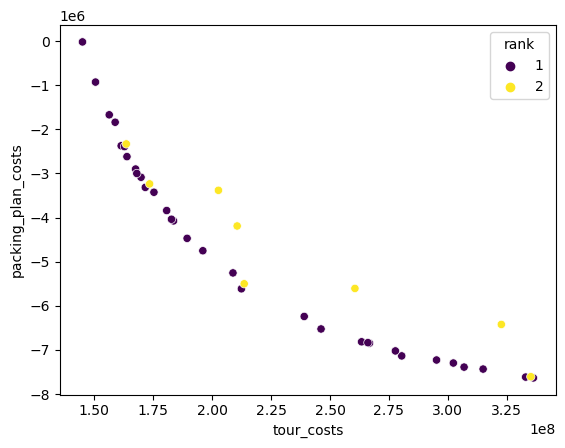

In [28]:
# copy from TTP_solver_with_experiments.ipynb
fnl4461_n22300_CSV = pd.read_csv('../experimental_data/np_fnl4461_n22300_end_populations.csv',sep = ";")
# fnl4461_n22300_CSV.head()
sns.scatterplot(x = fnl4461_n22300_CSV["tour_costs"], 
                y = fnl4461_n22300_CSV["packing_plan_costs"] * -1, 
                hue = fnl4461_n22300_CSV["rank"], 
                palette="viridis"
                )